# User Revokeable Distributed Auditing System

In [1]:
# Import required libraries
import os, sys, time
import hashlib
import socket, string
import pickle, shutil
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from cryptography.fernet import Fernet
from collections import defaultdict
from random import sample, randint, choice

## Important Directory Location

In [2]:
data_path = r"D:\User Data\Desktop\User_Revokeable_Distributed_Auditing_System\Data Owner\data"
cloud_path = r"D:\User Data\Desktop\User_Revokeable_Distributed_Auditing_System\Cloud Service Provider"
failure_reports_dir = r"D:\User Data\Desktop\User_Revokeable_Distributed_Auditing_System\Data Owner\failure_reports"
data_owner_ACL_path = r"D:\User Data\Desktop\User_Revokeable_Distributed_Auditing_System\Data Owner\DO_ACL.txt"
CSP_ACL_path =  r"D:\User Data\Desktop\User_Revokeable_Distributed_Auditing_System\Cloud Service Provider\CSP_ACL.txt"

## Hashing and Chipher Functions.

In [3]:
def generate_key():
    return Fernet.generate_key()

def encrypt(key, plaintext):
    fernet = Fernet(key)
    encrypted_text = fernet.encrypt(plaintext.encode())
    return encrypted_text.decode()

def decrypt(key, encrypted_text):
    fernet = Fernet(key)
    decrypted_text = fernet.decrypt(encrypted_text.encode())
    return decrypted_text.decode()

def hash_message(message):
    sha256_hash = hashlib.sha256()
    sha256_hash.update(message.encode())
    return sha256_hash.hexdigest()

def verify_hash(message, hash_value):
    return hash_message(message) == hash_value

## Sample Data Generator.

In [4]:
def generate_data(n_files, size):
    if not(os.path.exists(data_path)): os.mkdir(data_path)
    for file_id in range(0, n_files):
        path = data_path+"\\"+"file_"+str(file_id)+".txt"
        file = open(path, mode="w", encoding='utf-8')
        file.write("test "*(size*200))

## Data Owner Class 

In [5]:
class Data_owner:
    def __init__(self, user_id, version):
        self.user_id = str(user_id)
        self.encryption_key = None
        self.current_version = version
        
    def check_data(self, path):
        try: get_len = len(os.listdir(path))
        except: sys.exit("No such directory present")
        if get_len: return True
        else: return False

    def push_data(self, cloud_path, data_path, folder):
        if self.check_data(data_path):
            self.encryption_key = generate_key()
            cloud_path =  cloud_path + "\\" + folder
            if not(os.path.exists(cloud_path)): os.mkdir(cloud_path)
            for file in os.listdir(data_path):
                data_file = open(data_path+"\\"+file, mode="r", encoding='utf-8')
                plain_text = data_file.read()

                file_id = file[:-4]
                version = str(self.current_version)
                user_id = self.user_id
                encrypted_text = encrypt(self.encryption_key, plain_text)
                time_stamp = str(datetime.datetime.now())
                hash_value = hash_message(message = file_id+version+user_id+encrypted_text+time_stamp)

                file_info = {"File_ID": file_id, "Version":version, "User_ID": user_id, 
                             "Encrypted_Text": encrypted_text, "Time_Stamp":time_stamp, "Hash_Value": hash_value}

                with open(cloud_path+"\\"+file, "wb") as cloud_file:
                    pickle.dump(file_info, cloud_file)
                    
            return True
        else: return False


    def get_failure_reports(self,FR_path):
        return pd.read_csv(FR_path)
    
    def reverification(self, FR_path, cloud_dir_path):
        count = 0
        fialure_records = self.get_failure_reports(FR_path)
        for file_id in fialure_records["File_ID"]:
            cloud_file_path = cloud_dir_path+"\\"+file_id+".txt"
            file_data = pickle.load(open(cloud_file_path,"rb"))
            hash_text = "".join([file_data[key] for key in file_data.keys() if key!="Hash_Value"])
            if not(verify_hash(hash_text, file_data["Hash_Value"])):
                count = count + 1
        return count     


## Manual Corruption and directory deletion function

In [6]:
def delete_generated_data(dir_path):
     shutil.rmtree(dir_path)

def manual_corruption(per_corruption, n_files, cloud_path):
    n_corrupt = (per_corruption*n_files)//100
    corrupted_files = sample(range(n_files),n_corrupt)
    
    for file_id in corrupted_files:
        file_name = "file_"+str(file_id)+".txt"
        file = open(cloud_path+"\\"+file_name, "rb")
        file_data = pickle.load(file)
        updated_text = "corrupted_data "*randint(5,20)
        file_data["Encrypted_Text"] += updated_text
        with open(cloud_path+"\\"+file_name, "wb") as cloud_file:
            pickle.dump(file_data, cloud_file)
    
    return corrupted_files

## Auditing and Failure report Funtion

In [7]:
def auditing_process(cloud_path,name):
    failure_records = {}
    for i,file in enumerate(os.listdir(cloud_path+"\\"+name)):
        cloud_file_path = cloud_path+"\\"+name+"\\"+file
        
        file_data = pickle.load(open(cloud_file_path,"rb"))
        hash_text = "".join([file_data[key] for key in file_data.keys() if key!="Hash_Value"])
        
        if not(verify_hash(hash_text, file_data["Hash_Value"])):
            failure_records[file[:-4]] = [file_data["File_ID"], file_data["Version"], file_data["Time_Stamp"]]
    return failure_records

def generate_failure_report(failure_records, n_files, per):
    report_path = failure_reports_dir +"\\"+"n_files_"+str(n_files)+"_FR_"+str(per)+".csv"
    files_id = list(failure_records.keys())
    versions = [failure_records[Id][1] for Id in files_id]
    time_stamps = [failure_records[Id][2] for Id in files_id]
    report = {"File_ID": files_id, "Version": versions, "Time_Stamp": time_stamps}
    pd_report = pd.DataFrame(report)
    csv_report = pd_report.to_csv(report_path)
    return report_path

## Bot User

In [ ]:
file_size = 1
results = defaultdict(list)
for n_files in [1000,2000,4000,6000,10000]:
    for per in [1, 2, 3, 4, 5]:
        n_reverification = []
        for _ in range(20):
             # Step 1 
            data_owner = Data_owner(user_id = 1, version = 1)
            generate_data(n_files,1)
            data_owner.push_data(cloud_path, data_path, "first_commit")
            delete_generated_data(data_path)
            
            # Step 2
            manual_corruption(per,n_files,cloud_path+"\\"+"first_commit")
            
            reverification_time = 0
            for _ in range(10):
                # Step 3  
                failure_records = auditing_process(cloud_path,"first_commit")
                report_path = generate_failure_report(failure_records, n_files, per)

                # Step 4
                start = time.time()
                data_owner.reverification(report_path, cloud_path+"\\"+"first_commit")
                end = time.time()
                reverification_time += (end-start)
                os.remove(report_path)
            n_reverification.appned(reverification_time)
            delete_generated_data(cloud_path+"\\"+"first_commit")
        avg_reverification = sum(n_reverification)/20
        results[n_files*10].append(avg_reverification)
            
            
            

In [13]:
results = defaultdict(list)
for n_files in [1000,2000,3000,5000,10000]:
    for per in [1, 2, 3, 4, 5]:
        # Step 1 
        data_owner = Data_owner(user_id = 1, version = 1)
        generate_data(n_files,1)
        data_owner.push_data(cloud_path, data_path, "first_commit")
        delete_generated_data(data_path)

        # Step 2
        manual_corruption(per,n_files,cloud_path+"\\"+"first_commit")
        
        reverification_time = 0
        for _ in range(10):
            # Step 3  
            failure_records = auditing_process(cloud_path,"first_commit")
            report_path = generate_failure_report(failure_records,n_files,per)

            # Step 4
            start = time.time()
            data_owner.reverification(report_path, cloud_path+"\\"+"first_commit")
            end = time.time()
            reverification_time += (end-start)
            os.remove(report_path)
            
        delete_generated_data(cloud_path+"\\"+"first_commit")
        results[n_files].append(reverification_time)

0.2324235439300537 1000 1
0.08568549156188965 1000 2
0.10116076469421387 1000 3
0.1279006004333496 1000 4
0.13832902908325195 1000 5
0.08583188056945801 2000 1
0.1320502758026123 2000 2
0.16607332229614258 2000 3
0.23915338516235352 2000 4
0.21320343017578125 2000 5
0.11321377754211426 3000 1
0.14380383491516113 3000 2
0.23801589012145996 3000 3
0.26027631759643555 3000 4
0.33853697776794434 3000 5
0.14427471160888672 5000 1
0.23305511474609375 5000 2
0.3172917366027832 5000 3
0.4725606441497803 5000 4
0.5247054100036621 5000 5
0.23894023895263672 10000 1
0.40516185760498047 10000 2
0.686051607131958 10000 3
0.789910078048706 10000 4
0.9676785469055176 10000 5


In [25]:
# result_info = {key*10:value for key,value in results.items()}
# result_data = pd.DataFrame(result_info,index = [1,2,3,4,5])
# result_data.to_csv("Auditing_process_data.csv")
# result_data.head()

,10000,20000,30000,50000,100000
1,0.232424,0.085832,0.113214,0.144275,0.238940
2,0.085685,0.132050,0.143804,0.233055,0.405162
3,0.101161,0.166073,0.238016,0.317292,0.686052
4,0.127901,0.239153,0.260276,0.472561,0.789910
5,0.138329,0.213203,0.338537,0.524705,0.967679


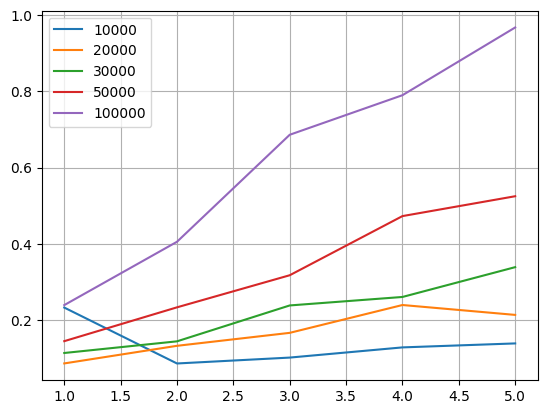

In [26]:
# import matplotlib.pyplot as plt
# result_data.plot()
# plt.grid()

# Scoket Programming

In [ ]:
# # client
# client_object = socket.socket(family=socket.AF_INET, type=socket.SOCK_STREAM)
# ip_address =  socket.gethostbyname(socket.gethostname())
# port = 5555
# client_object.connect((ip_address,port))
# data_receive = client_object.recv(1024)

# if data_receive:
#     print("CLIENT CONNECTED TO SERVER")
#     print(data_receive.decode('utf-8'))
#     while data_receive:
#         client_input = input().encode('utf-8')
#         client_object.send(client_input)
#         data_receive = client_object.recv(1024)
#         if data_receive:
#             print("{}: {}".format("SERVER",data_receive.decode('utf-8')))


In [ ]:
# # server
# server_object = socket.socket(family=socket.AF_INET, type=socket.SOCK_STREAM)
# ip_address = socket.gethostbyname(socket.gethostname())
# port = 5555
# server_object.bind((ip_address, port))
# server_object.listen()
# connection_object, _ = server_object.accept()

# if connection_object:
#     print("SERVER CONNECTED TO CLIENT")
#     connection_object.send(b"type the message")
#     data_receive = connection_object.recv(1024)
#     while data_receive != b'stop':
#         print("{}: {}".format("CLIENT MESSAGE: ", data_receive.decode('utf-8')))
#         server_input = random.choice(string.ascii_letters)
#         connection_object.send(server_input.encode('utf-8'))
#         data_receive = connection_object.recv(1024)


## Types of User

In [9]:

class Student:
    def __init__(self, user_id):
        self.user_id = user_id

    def check_permissions(self,file_id):
        pass
    def read_data(self,file_id):
        pass

    def write_data(self,file_id):
        pass

    def request_permission(self, file_id, mode):
        pass

    def auditing(self):
        pass


class Staff_member:
    def __init__(self, user_id):
        self.user_id = user_id

    def check_permissions(self,file_id):
        pass
    def read_data(self,file_id):
        pass

    def write_data(self,file_id):
        pass

    def request_permission(self, file_id, mode):
        pass

    def auditing(self):
        pass

    
class Faculty:
    def __init__(self, user_id):
        self.user_id = user_id

    def check_permissions(self,file_id):
        pass
    def read_data(self,file_id):
        pass

    def write_data(self,file_id):
        pass

    def request_permission(self, file_id, mode):
        pass

    def auditing(self):
        pass

## Access Control List 

In [4]:
class user_node:
    def __init__(self,file_id, mode, Next=None):
        self.file_id = file_id
        self.mode = mode
        self.next = Next
        
class ACL:
    def __init__(self, version, time_stamp):
        self.record = {}
        self.version = version
        self.time_stamp = time_stamp

    def remove_user(self, user_id):
        self.record[user_id] = None

    def add_user(self, user_id):
        if user_id in self.record: return False
        self.record[user_id] = None
        return True
    
    def traverse(self, user_id):
        head = self.record[user_id]
        if not(head): return
        while head.next!=None:
            print(head.file_id,end=" --> ")
            head = head.next
        print(head.file_id)
        
    def add_node(self, user_id, file_id, mode):
        if not(user_id in self.record): return False
        new_node = user_node(file_id, mode)
        head = self.record[user_id]
        new_node.next = head
        self.record[user_id] = new_node
        return True

## Generate Access Control list

In [5]:

def generate_ACL(n_user):
    time_stamp = str(datetime.datetime.now())
    sample_ACL = ACL(version = 1, time_stamp=time_stamp)
    for i in range(n_user):
        user_id = "user"+str(i+1)
        sample_ACL.add_user(user_id)
        n_node = randint(5,20)
        for j in range(n_node):
            file_id = "file_"+str(randint(0,100))
            mode = choice(["W","R"])
            sample_ACL.add_node(user_id, file_id, mode)
            
    return sample_ACL

def provide_ACL(n_user):
    sample_ACL = generate_ACL(n_users)
    ACL_data = {"Version": sample_ACL.version, "Time_stamp": sample_ACL.time_stamp, "ACL": sample_ACL.record } 

    with open(data_owner_ACL_path, "wb") as DO_ACL:
        pickle.dump(ACL_data, DO_ACL)

    with open(CSP_ACL_path, "wb") as CSP_ACL:
        pickle.dump(ACL_data, CSP_ACL)
        



## Simulating User Revocation process

In [6]:
results = defaultdict(list)

for n_users in [1000, 2000, 5000, 10000]:
    for per in [1, 2, 3, 4, 5]:
        provide_ACL(n_users)
        target = per*(n_users//100)
        user_ids = list(map(lambda x:"user"+str(x), sample(range(n_users),target)))
        
        start = time.time()
        ACL_data = pickle.load(open(data_owner_ACL_path, "rb"))
        ACL_data["Version"] += 1
        ACL_data["Time_stamp"] = str(datetime.datetime.now())
        for user in user_ids:
            ACL_data["ACL"][user] = None
        
        pickle.dump(ACL_data,open(data_owner_ACL_path, "wb"))
        DO_ACL_hash = hash_message(str(open(data_owner_ACL_path, "rb").read()))
        
        pickle.dump(ACL_data,open(CSP_ACL_path, "wb"))
        end = time.time()
        
        if not(verify_hash(str(open(CSP_ACL_path, "rb").read()), DO_ACL_hash)):
            print("Not_verified")
        
        results[n_users].append(end-start)


In [7]:
result_info = {key:value for key,value in results.items()}
result_data = pd.DataFrame(result_info,index = [1,2,3,4,5])
result_data.to_csv("user_recocation_data.csv")
result_data.head()

,1000,2000,5000,10000
1,0.086436,0.165200,0.678103,1.715952
2,0.101004,0.252003,1.020973,2.978161
3,0.170995,0.253249,0.940675,2.683095
4,0.096989,0.356004,0.783895,1.755255
5,0.081996,0.362135,0.916753,1.862943


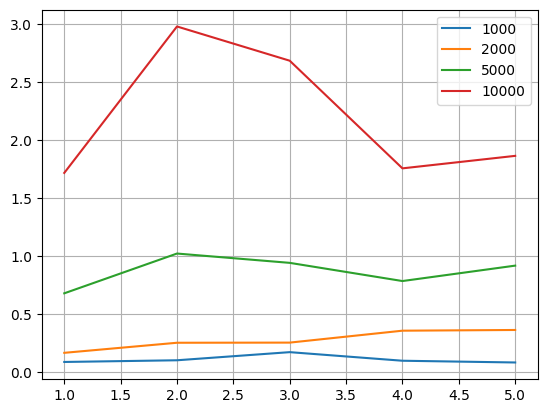

In [8]:
import matplotlib.pyplot as plt
result_data.plot()
plt.grid()